In [6]:
!pip install ultralytics
!pip install scikit-learn
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found exi

In [3]:
import os
import cv2
import numpy as np
from pathlib import Path
import glob

def convert_mask_to_polygon(mask_path, image_shape, output_dir, image_name):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        print(f"Cannot read mask: {mask_path}")
        return None
    
    if np.max(mask) == 0:
        output_txt = os.path.join(output_dir, f"{Path(image_name).stem}.txt")
        os.makedirs(output_dir, exist_ok=True)
        with open(output_txt, 'w') as f:
            pass
        return []
    
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img_height, img_width = image_shape
    polygons = []
    
    for contour in contours:
        if cv2.contourArea(contour) < 10:  # Lower threshold
            continue
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        points = []
        for point in approx:
            x, y = point[0]
            points.extend([x / img_width, y / img_height])
        if len(points) >= 6:
            polygons.append([0] + points)
    
    output_txt = os.path.join(output_dir, f"{Path(image_name).stem}.txt")
    os.makedirs(output_dir, exist_ok=True)
    with open(output_txt, 'w') as f:
        for poly in polygons:
            f.write(' '.join(f"{x:.6f}" for x in poly) + '\n')
    return polygons

def create_segmentation_labels(images_dir, masks_dir, output_labels_dir):
    img_files = glob.glob(os.path.join(images_dir, "*.png"))
    fire_count = normal_count = 0
    
    for img_path in img_files:
        img_name = Path(img_path).name
        mask_name = img_name.replace('.png', '_gt.png')
        mask_path = os.path.join(masks_dir, mask_name)
        if not os.path.exists(mask_path):
            print(f"Mask not found for image: {img_path}")
            continue
        img = cv2.imread(img_path)
        if img is None:
            print(f"Cannot read image: {img_path}")
            continue
        polygons = convert_mask_to_polygon(mask_path, img.shape[:2], output_labels_dir, img_name)
        if polygons is None:
            continue
        if len(polygons) > 0:
            fire_count += 1
        else:
            normal_count += 1
    
    print(f"Processed {len(img_files)} images: {fire_count} fire, {normal_count} normal")

# Configuration
images_dir = "/kaggle/input/object-detection-using-deep-learning/BoWFireDataset/dataset/img"
masks_dir = "/kaggle/input/object-detection-using-deep-learning/BoWFireDataset/dataset/gt"
output_labels_dir = "/kaggle/working/labels"

# Run
create_segmentation_labels(images_dir, masks_dir, output_labels_dir)

Processed 226 images: 119 fire, 107 normal


In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split
import glob
from pathlib import Path

def split_dataset(images_dir, labels_dir, train_dir, val_dir, split_ratio=0.8):
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    img_files = [Path(f).name for f in glob.glob(os.path.join(images_dir, "*.png"))]
    if not img_files:
        print(f"No images found in {images_dir}")
        return
    train_imgs, val_imgs = train_test_split(img_files, train_size=split_ratio, random_state=42)
    
    for img in train_imgs:
        img_path = os.path.join(images_dir, img)
        if os.path.exists(img_path):
            shutil.copy(img_path, os.path.join(train_dir, img))
            label_file = f"{Path(img).stem}.txt"
            label_path = os.path.join(labels_dir, label_file)
            if os.path.exists(label_path):
                shutil.copy(label_path, os.path.join(train_dir, label_file))
            else:
                with open(os.path.join(train_dir, label_file), 'w') as f:
                    pass
                print(f"Created empty label for train image: {img}")
    
    for img in val_imgs:
        img_path = os.path.join(images_dir, img)
        if os.path.exists(img_path):
            shutil.copy(img_path, os.path.join(val_dir, img))
            label_file = f"{Path(img).stem}.txt"
            label_path = os.path.join(labels_dir, label_file)
            if os.path.exists(label_path):
                shutil.copy(label_path, os.path.join(val_dir, label_file))
            else:
                with open(os.path.join(val_dir, label_file), 'w') as f:
                    pass
                print(f"Created empty label for val image: {img}")
    
    print(f"Train images: {len(train_imgs)}, Val images: {len(val_imgs)}")

# Configuration
images_dir = "/kaggle/input/object-detection-using-deep-learning/BoWFireDataset/dataset/img"
labels_dir = "/kaggle/working/labels"
train_dir = "/kaggle/working/train_images"
val_dir = "/kaggle/working/val_images"

# Run
split_dataset(images_dir, labels_dir, train_dir, val_dir)

Train images: 180, Val images: 46


In [9]:
import os
import yaml

# Define the data.yaml content
data_yaml = {
    'train': '/kaggle/working/train_images',
    'val': '/kaggle/working/val_images',
    'nc': 1,
    'names': ['fire']
}

# Save to /kaggle/working/data.yaml
output_path = '/kaggle/working/data.yaml'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
with open(output_path, 'w') as f:
    yaml.dump(data_yaml, f, default_flow_style=False)

print(f"Created data.yaml at {output_path}")


Created data.yaml at /kaggle/working/data.yaml


In [16]:
from ultralytics import YOLO

# Load segmentation model
model = YOLO("yolov8n-seg.pt")  # Use pre-trained YOLOv8 nano segmentation model

# Train
model.train(
    data="/kaggle/working/data.yaml",
    epochs=50,
    imgsz=640,
    batch=16,
    name="fire_segmentation",
    device=0,  # Use GPU
    patience=10,  # Early stopping
    augment=True,  # Enable augmentation
    hsv_h=0.02,  # Increase hue augmentation
    hsv_s=0.8,  # Increase saturation augmentation
    hsv_v=0.5,  # Increase value augmentation
    mosaic=0.8  # Slightly reduce mosaic for segmentation
)

Ultralytics 8.3.146 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.02, hsv_s=0.8, hsv_v=0.5, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-seg.pt, momentum=0.937, mosaic=0.8, multi_scale=False, name=fire_segmentation3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plots=True, p

train: Scanning /kaggle/working/train_images.cache... 180 images, 83 backgrounds, 0 corrupt: 100%|██████████| 180/180 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1122.2±1573.9 MB/s, size: 1369.8 KB)


val: Scanning /kaggle/working/val_images.cache... 46 images, 24 backgrounds, 0 corrupt: 100%|██████████| 46/46 [00:00<?, ?it/s]


Plotting labels to runs/segment/fire_segmentation3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/fire_segmentation3
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/50      3.55G      1.891       4.17      3.926      1.522         45        640: 100%|██████████| 12/12 [00:04<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.38it/s]

                   all         46        191    0.00348      0.251     0.0449     0.0254    0.00348      0.251     0.0521     0.0197



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.94G      1.573      3.274      2.529      1.246         32        640: 100%|██████████| 12/12 [00:03<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.87it/s]

                   all         46        191    0.00457       0.33     0.0596     0.0359    0.00449      0.325     0.0634     0.0235



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/50      5.94G      1.678      2.986       2.43      1.252         69        640: 100%|██████████| 12/12 [00:03<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.72it/s]


                   all         46        191       0.45     0.0105     0.0517     0.0211       0.55     0.0131     0.0505      0.016

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/50      5.94G      1.733      3.019      2.391      1.319         19        640: 100%|██████████| 12/12 [00:03<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

                   all         46        191       0.32     0.0838     0.0689     0.0298      0.252     0.0681     0.0471     0.0216



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/50      5.94G      1.728      3.007      2.182      1.285         79        640: 100%|██████████| 12/12 [00:03<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.10it/s]

                   all         46        191      0.558     0.0733     0.0804     0.0389      0.518     0.0681     0.0647     0.0286



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/50      5.94G      1.767      2.873       2.17      1.303         23        640: 100%|██████████| 12/12 [00:03<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.13it/s]

                   all         46        191      0.217      0.105     0.0744     0.0342      0.233     0.0628     0.0495       0.02



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/50      5.94G      1.681      2.989      2.094      1.268         24        640: 100%|██████████| 12/12 [00:03<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.26it/s]

                   all         46        191       0.22      0.155     0.0919     0.0389      0.157      0.115     0.0639     0.0236



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/50      5.94G      1.693       2.86      2.336      1.284         23        640: 100%|██████████| 12/12 [00:03<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.95it/s]

                   all         46        191      0.228     0.0838     0.0657       0.03     0.0407     0.0524     0.0107     0.0034



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/50      5.94G      1.726      2.946      2.027      1.282         33        640: 100%|██████████| 12/12 [00:03<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.41it/s]

                   all         46        191      0.187     0.0785     0.0564     0.0289     0.0865     0.0942     0.0424     0.0109



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/50      5.94G      1.726      3.007      2.056      1.272          7        640: 100%|██████████| 12/12 [00:03<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.94it/s]

                   all         46        191      0.194      0.147       0.08     0.0319      0.123      0.147     0.0615     0.0223



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/50      5.94G      1.744      3.048      1.951      1.303         45        640: 100%|██████████| 12/12 [00:03<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.68it/s]

                   all         46        191      0.174      0.141     0.0839     0.0422      0.201       0.11     0.0788     0.0267



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.94G      1.724      2.952      1.904      1.279         28        640: 100%|██████████| 12/12 [00:02<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

                   all         46        191      0.302      0.215      0.144     0.0605      0.253      0.204      0.139     0.0484



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/50      5.94G      1.697      2.939      1.894      1.282         15        640: 100%|██████████| 12/12 [00:03<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.43it/s]

                   all         46        191      0.273      0.241      0.141     0.0583      0.212      0.178      0.105     0.0389



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/50      5.94G      1.843      3.109      2.843      1.339          5        640: 100%|██████████| 12/12 [00:02<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.01it/s]

                   all         46        191       0.32      0.232      0.175     0.0653       0.27      0.195      0.125     0.0375



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.94G      1.632      2.647      1.813      1.271         20        640: 100%|██████████| 12/12 [00:03<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.62it/s]

                   all         46        191       0.37      0.241      0.194     0.0791      0.301      0.251      0.172     0.0598



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.94G      1.615       2.81      1.727      1.225         18        640: 100%|██████████| 12/12 [00:03<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.43it/s]

                   all         46        191      0.282      0.267      0.186     0.0826      0.269      0.257      0.182     0.0671



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.94G      1.518      2.593      1.606      1.197         24        640: 100%|██████████| 12/12 [00:03<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.88it/s]

                   all         46        191      0.317      0.262      0.207      0.098      0.324      0.309      0.202     0.0796



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.94G      1.595       2.74      1.574       1.21         24        640: 100%|██████████| 12/12 [00:03<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.33it/s]

                   all         46        191      0.406       0.25      0.217      0.111      0.311      0.267      0.218     0.0947



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/50      5.94G      1.603       2.84      1.654      1.223         62        640: 100%|██████████| 12/12 [00:03<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.35it/s]

                   all         46        191      0.386      0.257       0.23      0.116      0.337      0.267      0.236      0.105



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/50      5.94G      1.597      2.705       1.55      1.199         65        640: 100%|██████████| 12/12 [00:03<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.58it/s]

                   all         46        191      0.349      0.284      0.221      0.107      0.355      0.288      0.217     0.0823



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/50      5.94G      1.587      2.617      1.519      1.217         20        640: 100%|██████████| 12/12 [00:03<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.23it/s]

                   all         46        191        0.4      0.288      0.255      0.121      0.396      0.302      0.253      0.106



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/50      5.94G      1.527      2.699      1.437      1.175         34        640: 100%|██████████| 12/12 [00:03<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.10it/s]

                   all         46        191      0.357      0.277       0.24      0.116      0.353      0.288      0.239     0.0971



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/50      5.94G      1.491      2.615      1.497      1.176         23        640: 100%|██████████| 12/12 [00:03<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.83it/s]

                   all         46        191      0.396      0.304      0.264      0.134      0.402      0.307      0.286      0.119



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/50      5.94G       1.49      2.521      1.369      1.167         34        640: 100%|██████████| 12/12 [00:03<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.90it/s]

                   all         46        191      0.376      0.293      0.263      0.122      0.389      0.304      0.277      0.108



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/50      5.94G      1.479      2.515      1.398      1.177         24        640: 100%|██████████| 12/12 [00:03<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.13it/s]

                   all         46        191      0.582      0.241      0.271      0.141      0.398       0.34      0.298      0.122



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.94G      1.447      2.551      1.307      1.145         48        640: 100%|██████████| 12/12 [00:03<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.34it/s]

                   all         46        191      0.368      0.314      0.265      0.132      0.368      0.314      0.257      0.112



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.94G      1.443      2.563      1.343       1.17         18        640: 100%|██████████| 12/12 [00:03<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.51it/s]

                   all         46        191      0.394      0.346      0.274      0.127      0.406      0.373      0.284      0.112



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/50      5.94G      1.388      2.515      1.341      1.112         55        640: 100%|██████████| 12/12 [00:03<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.40it/s]

                   all         46        191      0.339      0.277      0.243       0.12      0.365      0.298      0.257      0.104



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.94G      1.475      2.519      1.323      1.136         23        640: 100%|██████████| 12/12 [00:03<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.31it/s]

                   all         46        191      0.413      0.304      0.266      0.143      0.429      0.293      0.265      0.116



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.94G      1.376      2.418      1.294      1.108         36        640: 100%|██████████| 12/12 [00:03<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]

                   all         46        191      0.474      0.319      0.308      0.165      0.491       0.33      0.319      0.138



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.94G      1.438      2.485      1.293      1.117         24        640: 100%|██████████| 12/12 [00:03<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.43it/s]

                   all         46        191      0.383      0.325       0.29      0.155      0.423       0.34      0.311      0.125



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.94G       1.33      2.495      1.227      1.091         28        640: 100%|██████████| 12/12 [00:03<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.97it/s]

                   all         46        191       0.41      0.276      0.264       0.14      0.444      0.267      0.281      0.121



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      33/50      5.94G      1.436      2.511      1.254      1.118         31        640: 100%|██████████| 12/12 [00:03<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.34it/s]

                   all         46        191      0.365      0.309      0.277      0.134      0.386      0.319      0.281      0.108



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.94G       1.39      2.538      1.221        1.1         72        640: 100%|██████████| 12/12 [00:03<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.88it/s]

                   all         46        191      0.326       0.33      0.258      0.131       0.39      0.328      0.261      0.107



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      35/50      5.94G      1.395      2.447      1.225      1.135         37        640: 100%|██████████| 12/12 [00:03<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.18it/s]

                   all         46        191      0.395      0.346      0.283      0.145      0.372       0.33      0.267      0.114



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.94G       1.27      2.295      1.162      1.068         22        640: 100%|██████████| 12/12 [00:03<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.04it/s]

                   all         46        191      0.335       0.33      0.249      0.128      0.348      0.325      0.265      0.106



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      37/50      5.94G      1.338      2.491      1.228      1.082         25        640: 100%|██████████| 12/12 [00:03<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.97it/s]

                   all         46        191      0.378       0.33      0.267      0.131      0.384      0.346      0.275      0.114



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      38/50      5.94G      1.362      2.368      1.196       1.08         30        640: 100%|██████████| 12/12 [00:03<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.39it/s]

                   all         46        191      0.377       0.33      0.274      0.139      0.346      0.322      0.276      0.122



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      39/50      5.94G      1.272      2.303      1.119      1.038         33        640: 100%|██████████| 12/12 [00:03<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]

                   all         46        191      0.387       0.34      0.267       0.14      0.388      0.339      0.275      0.118



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      40/50      5.94G      1.249      2.291      1.059      1.042         17        640: 100%|██████████| 12/12 [00:03<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.14it/s]

                   all         46        191      0.373       0.34      0.273      0.147      0.405      0.351      0.272      0.121
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 30, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



40 epochs completed in 0.045 hours.
Optimizer stripped from runs/segment/fire_segmentation3/weights/last.pt, 6.8MB
Optimizer stripped from runs/segment/fire_segmentation3/weights/best.pt, 6.8MB

Validating runs/segment/fire_segmentation3/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv8n-seg summary (fused): 85 layers, 3,258,259 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:00<00:00,  2.96it/s]

WARNING ⚠️ Model does not support 'augment=True', reverting to single-scale prediction.
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         46        191      0.485      0.325      0.318      0.166      0.493       0.33      0.319      0.137
Speed: 0.1ms preprocess, 3.3ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/segment/fire_segmentation3


ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f988c184890>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041, 


image 1/1 /kaggle/input/object-detection-using-deep-learning/BoWFireDataset/dataset/img/not_fire093.png: 448x640 (no detections), 7.8ms
Speed: 2.1ms preprocess, 7.8ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /kaggle/input/object-detection-using-deep-learning/BoWFireDataset/dataset/img/not_fire053.png: 448x640 (no detections), 8.6ms
Speed: 2.4ms preprocess, 8.6ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /kaggle/input/object-detection-using-deep-learning/BoWFireDataset/dataset/img/not_fire003.png: 480x640 (no detections), 8.2ms
Speed: 2.4ms preprocess, 8.2ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /kaggle/input/object-detection-using-deep-learning/BoWFireDataset/dataset/img/fire099.png: 480x640 3 fires, 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /kaggle/input/object-detection-using-deep-learning/BoWFireDataset/dat

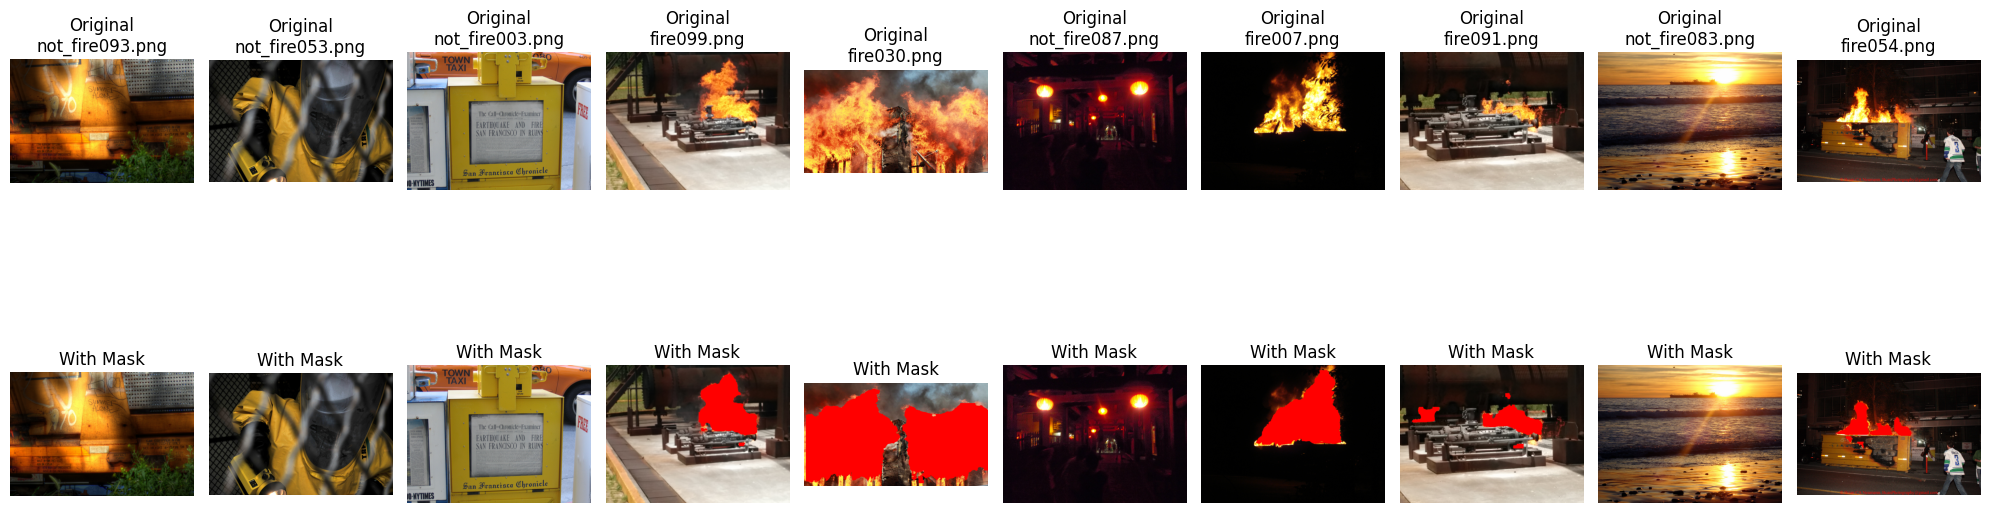

In [27]:

from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob
import random
from pathlib import Path

# Load model
model = YOLO("/kaggle/working/runs/segment/fire_segmentation3/weights/best.pt")

# Get list of images
images_dir = "/kaggle/input/object-detection-using-deep-learning/BoWFireDataset/dataset/img"
img_files = glob.glob(f"{images_dir}/*.png")
if not img_files:
    print(f"No images found in {images_dir}")
else:
    # Select 10 random images
    test_images = random.sample(img_files, min(10, len(img_files)))
    
    # Set up plot
    plt.figure(figsize=(20, 8))
    
    for i, test_image in enumerate(test_images):
        # Predict
        results = model.predict(test_image, conf=0.3)  # Lower confidence threshold
        
        # Load image
        img = cv2.imread(test_image)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Create a copy for mask overlay
        img_with_mask = img_rgb.copy()
        
        # Draw predicted masks
        if results[0].masks is not None:
            for mask in results[0].masks.data:
                mask = mask.cpu().numpy()  # Convert to numpy
                mask = cv2.resize(mask, (img.shape[1], img.shape[0]))  # Resize to image size
                img_with_mask[mask > 0.5] = (255, 0, 0)  # Color fire regions red
        
        # Plot original image
        plt.subplot(2, 10, i + 1)
        plt.imshow(img_rgb)
        plt.title(f"Original\n{Path(test_image).name}")
        plt.axis('off')
        
        # Plot image with mask
        plt.subplot(2, 10, i + 11)
        plt.imshow(img_with_mask)
        plt.title("With Mask")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()